# Exploring Usage Patterns and Trends in Bikesharing Data: Insights for Improved Ride-Sharing Experience | Using Apache Spark

The objective of this project is to analyze data and extract valuable insights regarding usage patterns, popular routes, and other trends. 

The insights obtained from the analysis can be used to improve the overall experience of the ride-sharing service and provide better recommendations to the customers.

In [ ]:
# Import  libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *


In [ ]:
spark = SparkSession.builder.appName("BikeSharingAnalysis").getOrCreate()

# Data Preprocessing

In [ ]:
df = spark.read.csv("202212-capitalbikeshare-tripdata.csv", header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



In [ ]:
df.count()

175233

In [ ]:
df.show(5)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+---------+----------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat| start_lng|  end_lat|   end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+---------+----------+-------------+
|1C109AA07D71B300| classic_bike|2022-12-02 11:59:29|2022-12-02 12:02:44|17th St & Massach...|           31267|Massachusetts Ave...|         31200|38.908142|-77.038359|  38.9101|  -77.0444|       member|
|DD4F1F66ACD60BDA| classic_bike|2022-12-14 19:09:35|2022-12-14 19:47:14|C & O Canal & Wis...|           31225|       8th & F St NE|         31631| 38.90375| -77.06269|38.897274|-76.994749|

In [ ]:
# Empty val
empty_row_counts = df.agg(*[sum(isnull(c).cast("int")).alias(c) for c in df.columns])

empty_row_counts.show()

+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+
|ride_id|rideable_type|started_at|ended_at|start_station_name|start_station_id|end_station_name|end_station_id|start_lat|start_lng|end_lat|end_lng|member_casual|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+
|      0|            0|         0|       0|              9238|            9238|           10163|         10163|        0|        0|    208|    208|            0|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+



In [ ]:
## We have few empty rows in certain columns we can drop them anD work with the remaining data (92%)
df_clean = df.dropna()

In [ ]:
df_clean.count()

161308

In [ ]:
# Empty val
empty_row_counts = df_clean.agg(*[sum(isnull(c).cast("int")).alias(c) for c in df_clean.columns])

empty_row_counts.show()

+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+
|ride_id|rideable_type|started_at|ended_at|start_station_name|start_station_id|end_station_name|end_station_id|start_lat|start_lng|end_lat|end_lng|member_casual|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+
|      0|            0|         0|       0|                 0|               0|               0|             0|        0|        0|      0|      0|            0|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+



In [ ]:
df_clean.write.csv("ml_data.csv", header=True)


# Anlyzing DATA : 


## Popular routes:


In [ ]:

popular_routes = df_clean.groupBy("start_station_name", "end_station_name") \
                   .agg(count("*").alias("num_rides")) \
                   .orderBy("num_rides", ascending=False)

In [ ]:
popular_routes.show()

+--------------------+--------------------+---------+
|  start_station_name|    end_station_name|num_rides|
+--------------------+--------------------+---------+
|Columbus Circle /...|       8th & F St NE|      232|
|       8th & F St NE|Columbus Circle /...|      198|
|Smithsonian-Natio...|Smithsonian-Natio...|      151|
|Columbus Circle /...|       6th & H St NE|      145|
|4th St & Madison ...|4th St & Madison ...|      135|
|Eastern Market Me...|Lincoln Park / 13...|      126|
|Jefferson Dr & 14...|Jefferson Dr & 14...|      123|
|New Hampshire Ave...|      15th & P St NW|      105|
|       6th & H St NE|Columbus Circle /...|      105|
|Jefferson Dr & 14...|    Lincoln Memorial|      102|
|      15th & P St NW|New Hampshire Ave...|      100|
|New Hampshire Ave...|      17th & K St NW|       96|
|Smithsonian-Natio...|    Lincoln Memorial|       94|
|    Lincoln Memorial|    Lincoln Memorial|       91|
|New Hampshire Ave...|18th & New Hampsh...|       89|
|      15th & P St NW|      

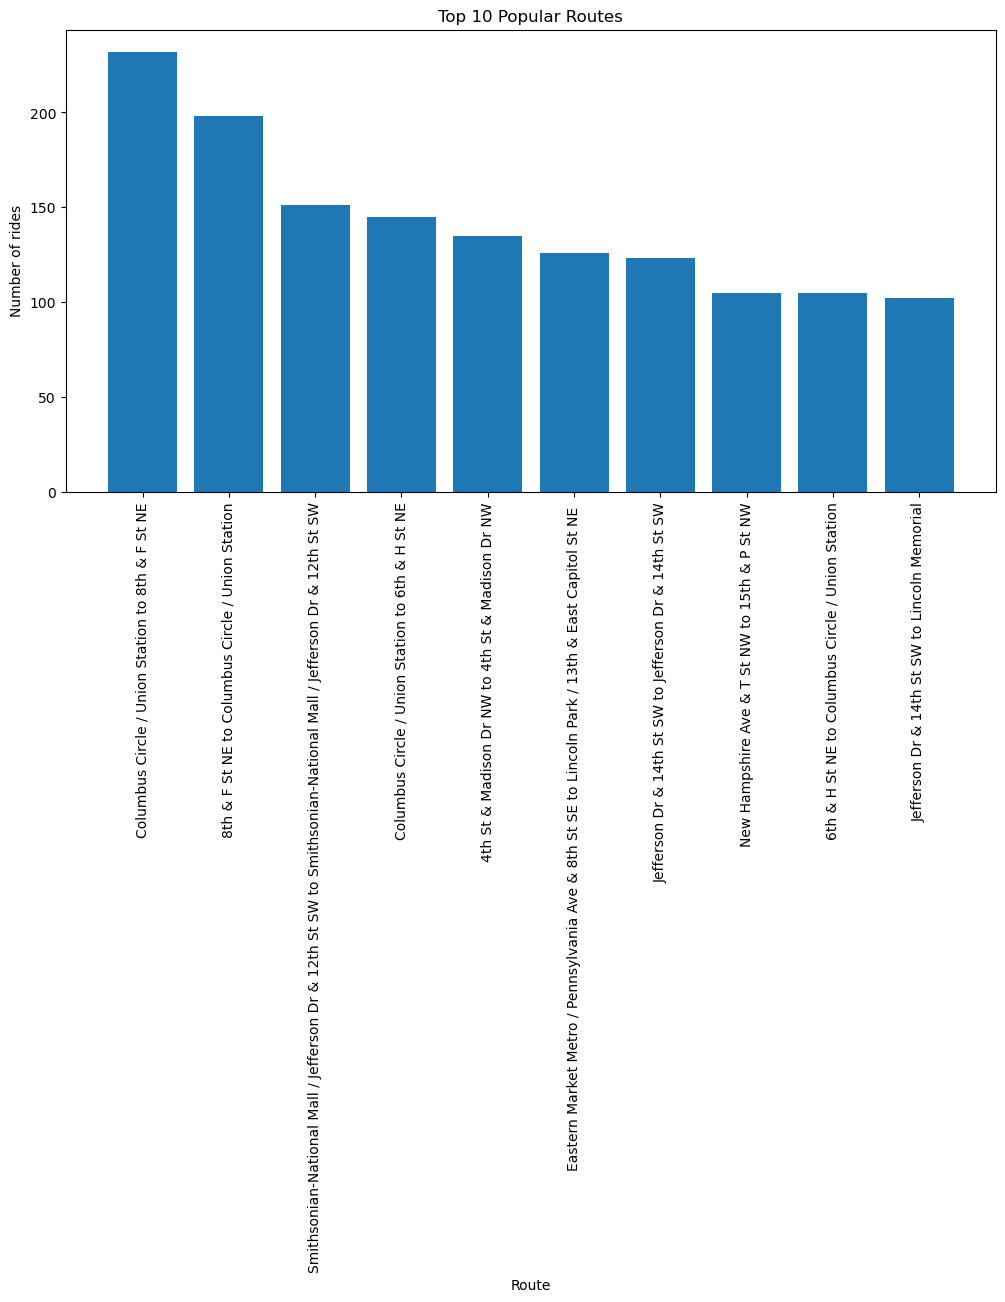

In [ ]:
# Top 10 POPULAR ROUTES : 

import matplotlib.pyplot as plt

top_routes = popular_routes.limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(x=range(len(top_routes)), height=top_routes['num_rides'])
plt.xticks(range(len(top_routes)), [f"{start} to {end}" for start, end in zip(top_routes['start_station_name'], top_routes['end_station_name'])], rotation=90)
plt.xlabel('Route')
plt.ylabel('Number of rides')
plt.title('Top 10 Popular Routes')
plt.show()

## Usage Pattern 

### I - Rides by hour of day


In [ ]:
rides_by_hour = df_clean.withColumn('hour', hour('started_at'))

In [ ]:
# create a new column with the hour of day for each ride
rides_by_hour = rides_by_hour.groupBy("hour") \
                   .agg(count("*").alias("num_rides"))

rides_by_hour = rides_by_hour.orderBy('num_rides',ascending=False)

rides_by_hour.show(24)

+----+---------+
|hour|num_rides|
+----+---------+
|  17|    14790|
|  16|    13606|
|  18|    12633|
|  15|    12164|
|  13|    10957|
|  14|    10790|
|   8|    10353|
|  12|    10079|
|  19|     9106|
|  11|     8353|
|   9|     8218|
|  10|     7152|
|   7|     6300|
|  20|     6273|
|  21|     5072|
|  22|     4150|
|  23|     3122|
|   6|     2813|
|   0|     1858|
|   1|     1127|
|   5|     1045|
|   2|      703|
|   4|      329|
|   3|      315|
+----+---------+



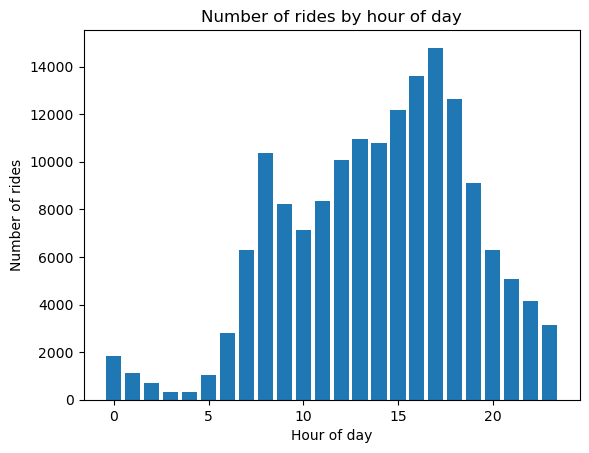

In [ ]:
rides_by_hour_pd = rides_by_hour.toPandas()

# create a line chart with the hour of day on the x-axis and the number of rides on the y-axis
plt.bar(rides_by_hour_pd['hour'], rides_by_hour_pd['num_rides'])

# set the chart title and axis labels
plt.title('Number of rides by hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Number of rides')

# show the chart
plt.show()

### II - Rides by day of week:


In [ ]:

rides_by_dayofweek = df_clean.withColumn('dayofweek', date_format('started_at', 'E'))

# group the data by day of week and count the number of rides
rides_by_dayofweek = rides_by_dayofweek.groupBy('dayofweek').agg(count('*').alias('num_rides'))

weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

rides_by_dayofweek = rides_by_dayofweek.orderBy('num_rides' , ascending=False)

rides_by_dayofweek.show()

+---------+---------+
|dayofweek|num_rides|
+---------+---------+
|      Fri|    30381|
|      Sat|    24927|
|      Thu|    24667|
|      Wed|    23734|
|      Tue|    20492|
|      Mon|    18994|
|      Sun|    18113|
+---------+---------+



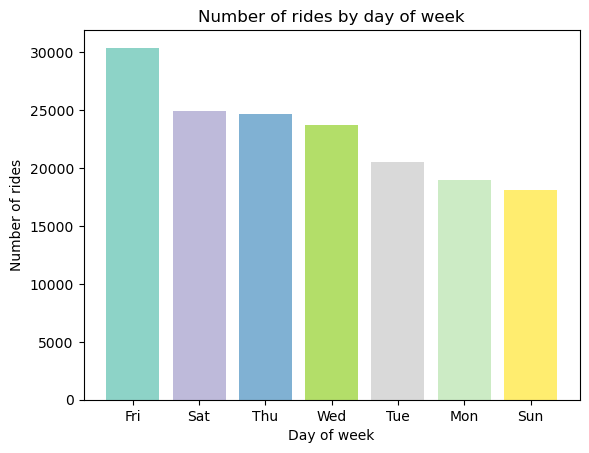

In [ ]:
import numpy as np


rides_by_dayofweek_pd = rides_by_dayofweek.toPandas()
#-
cmap = plt.get_cmap('Set3')
colors = [cmap(i) for i in np.linspace(0, 1, len(rides_by_dayofweek_pd['dayofweek'].unique()))]
#- 

plt.bar(rides_by_dayofweek_pd['dayofweek'], rides_by_dayofweek_pd['num_rides'], color=colors)
plt.title('Number of rides by day of week')
plt.xlabel('Day of week')
plt.ylabel('Number of rides')

# show the chart
plt.show()



### Combination between the usage in days and hours 

/tmp/ipykernel_3130/3950074584.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  rides_by_hour_and_day_matrix = rides_by_hour_and_day_pd.pivot('hour', 'day', 'count')


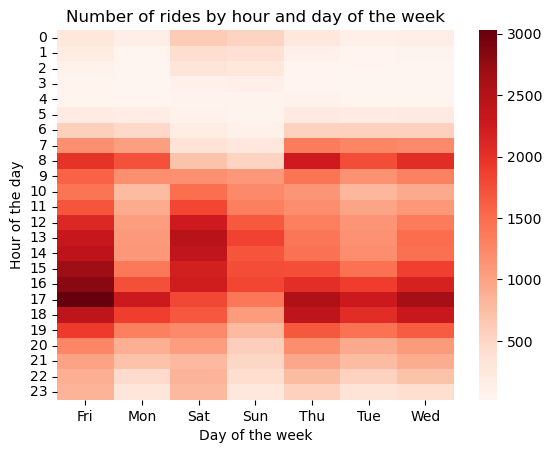

In [ ]:
import seaborn as sns 

import pyspark.sql.functions as F

# Aggregate the data by hour and day of the week
rides_by_hour_and_day = df.groupby(F.hour('started_at').alias('hour'), F.date_format('started_at', 'E').alias('day')).count()

rides_by_hour_and_day_pd = rides_by_hour_and_day.toPandas()

rides_by_hour_and_day_matrix = rides_by_hour_and_day_pd.pivot('hour', 'day', 'count')

sns.heatmap(rides_by_hour_and_day_matrix, cmap='Reds')

plt.title('Number of rides by hour and day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Hour of the day')


plt.show()


### III- Rides by months

In [ ]:
# We got only month 12 in our current data 

In [ ]:
rides_by_month = df_clean.withColumn('month', month('started_at'))

rides_by_month = rides_by_month.groupBy('month').agg(count('*').alias('num_rides'))

rides_by_month = rides_by_month.orderBy('month')

rides_by_month.show()


+-----+---------+
|month|num_rides|
+-----+---------+
|   12|   161308|
+-----+---------+



### Ride duration

In [ ]:
# calculate ride duration in minutes
df_clean = df_clean.withColumn('duration_minutes', (unix_timestamp('ended_at') - unix_timestamp('started_at')) / 60)


# aggregate by average ride duration by day
duration_by_day = df_clean.groupBy(date_trunc('day', 'started_at').alias('date')).avg('duration_minutes')
duration_by_day = duration_by_day.orderBy('avg(duration_minutes)',  ascending=False)

duration_by_day.show()


+-------------------+---------------------+
|               date|avg(duration_minutes)|
+-------------------+---------------------+
|2022-12-30 00:00:00|    22.29162704701533|
|2022-12-29 00:00:00|   21.274510556621852|
|2022-12-28 00:00:00|   20.653383250138706|
|2022-12-31 00:00:00|   20.450288490737883|
|2022-12-25 00:00:00|   20.319878253568433|
|2022-12-26 00:00:00|   18.889963054187184|
|2022-12-10 00:00:00|   18.593708736928377|
|2022-12-17 00:00:00|    17.92542798806348|
|2022-12-03 00:00:00|   17.889236298292843|
|2022-12-27 00:00:00|    17.82567300696391|
|2022-12-24 00:00:00|   16.327724014336912|
|2022-12-21 00:00:00|   15.780114278121063|
|2022-12-08 00:00:00|   15.633666666666715|
|2022-12-02 00:00:00|   15.545000645078092|
|2022-12-16 00:00:00|   15.531896551724104|
|2022-12-04 00:00:00|   15.426615392274005|
|2022-12-11 00:00:00|   15.413154337010647|
|2022-12-23 00:00:00|    15.21100136239781|
|2022-12-13 00:00:00|   15.101181465308114|
|2022-12-09 00:00:00|   15.07186

/home/aym0ane/spark-3.3.0-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


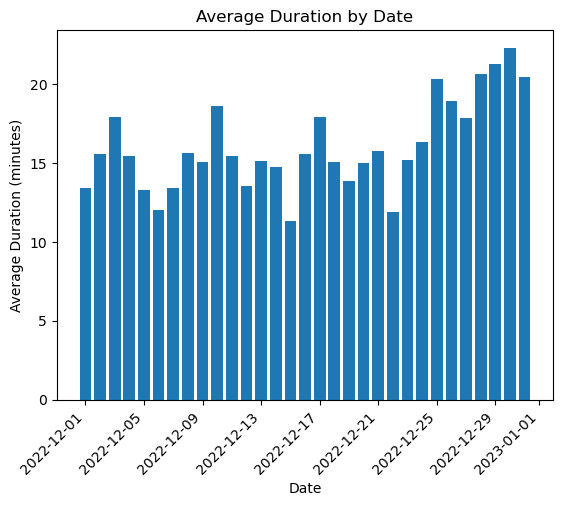

In [ ]:
avg_duration_pd = duration_by_day.toPandas()

# plot the average duration by date using Matplotlib
plt.bar(avg_duration_pd['date'], avg_duration_pd['avg(duration_minutes)'])
plt.xlabel('Date')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Duration by Date')
plt.xticks(rotation=45, ha='right')
plt.show()

#

######                                                                                                                                                     Data preprocessing and analysis Done
###### Aymane maane  